# 
This notebook serves as an exploratory environment to visualize and analyze the various metrics
computed in `compute_metrics.py`. It provides better insight into the data processing pipeline, allowing
easier debugging, visualization, and fine-tuning of parameters before running the final script.

It includes functions for:
- Loading and cleaning histogram data
- Computing detection efficiency
- Computing single-photon probability
- Computing availability metrics
- Visualizing histograms and final metrics


In [308]:
import numpy as np
import pandas as pd

filename = "/home/gsourpi/git-ldm/ldm/MultiHarp150_V3_1/HPM_TDC_Deadtime_Characterization/histograms/hist_output_delay_500ps_4.txt"
data = pd.read_csv(filename, sep='\s+', header=None)
non_zero_columns = (data != 0).any()
data = data.loc[:, non_zero_columns]
time_ps = np.arange(len(data))

histograms = {col: data[col].tolist() for col in data.columns}

ref_hist      = np.array(histograms[list(histograms.keys())[0]])
delay_hist    = np.array(histograms[list(histograms.keys())[1]])
detector_hist = np.array(histograms[list(histograms.keys())[2]])

In [292]:
print(f"Total number of pulses sent: {sum(ref_hist) + sum(delay_hist)}")
print(f"Total number of pulses measured: {sum(detector_hist)}")
tot_pulses = sum(detector_hist)
print(f"Number of missed pulses (sent but not measured): {sum(ref_hist) + sum(delay_hist) - sum(detector_hist)}")
print(f"Detection effeciency: { sum(detector_hist) / (sum(ref_hist) + sum(delay_hist))}")

Total number of pulses sent: 20000271
Total number of pulses measured: 6383
Number of missed pulses (sent but not measured): 19993888
Detection effeciency: 0.00031914567557609594


## Because there might be more than 2 peaks due to fluctuations we will apply gaussian fit to get the mean of our distributions

In [309]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, a, mu, sigma):
    """Gaussian function."""
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

def fit_gaussian(data, plot=True):

    data = np.array(data)
    x =time_ps
    
    a_guess = np.max(data)
    mu_guess = np.sum(x * data) / np.sum(data)  # Weighted mean
    sigma_guess = np.sqrt(np.sum(data * (x - mu_guess) ** 2) / np.sum(data))  # Weighted std dev

    p0 = [a_guess, mu_guess, sigma_guess]

    popt, pcov = curve_fit(gaussian, x, data, p0=p0)
    return popt, pcov

pump_params, _ = fit_gaussian(ref_hist)
probe_params , _ = fit_gaussian(delay_hist)

delay_bins = probe_params[1] - pump_params[1]
delay_ps   = delay_bins*5
print(delay_ps)

347.4349559028269


# Plot Histograms

In [312]:
import numpy as np
import plotly.graph_objects as go

time_ps_scaled = time_ps *5

# # Reference Histogram
# fig1 = go.Figure()
# fig1.add_trace(go.Scatter(x=time_ps_scaled, y=ref_hist, mode='lines+markers', name="Reference Histogram"))
# fig1.update_layout(title="Reference - Pump Histogram",
#                    xaxis_title="Time (ps)", yaxis_title="Counts",
#                    template="plotly_white")
# fig1.show()

# #  Delay Histogram
# fig2 = go.Figure()
# fig2.add_trace(go.Scatter(x=time_ps_scaled, y=delay_hist, mode='lines+markers', name="Delay Histogram", line=dict(color='red')))
# fig2.update_layout(title="Delay - Probe Histogram",
#                    xaxis_title="Time (ps)", yaxis_title="Counts",
#                    template="plotly_white")
# fig2.show()

# Detector Histogram
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=time_ps_scaled, y=detector_hist, mode='lines+markers', name="Detector Histogram", line=dict(color='green')))
fig3.update_yaxes(type="log")
fig3.update_layout(title="Detector Histogram",
                   xaxis_title="Time (ps)", yaxis_title="Counts",
                   template="plotly_white")
fig3.show()


In [239]:
print(2665- 3513)
print(np.sqrt(3513))
3697
4451

-848
59.270566050949775


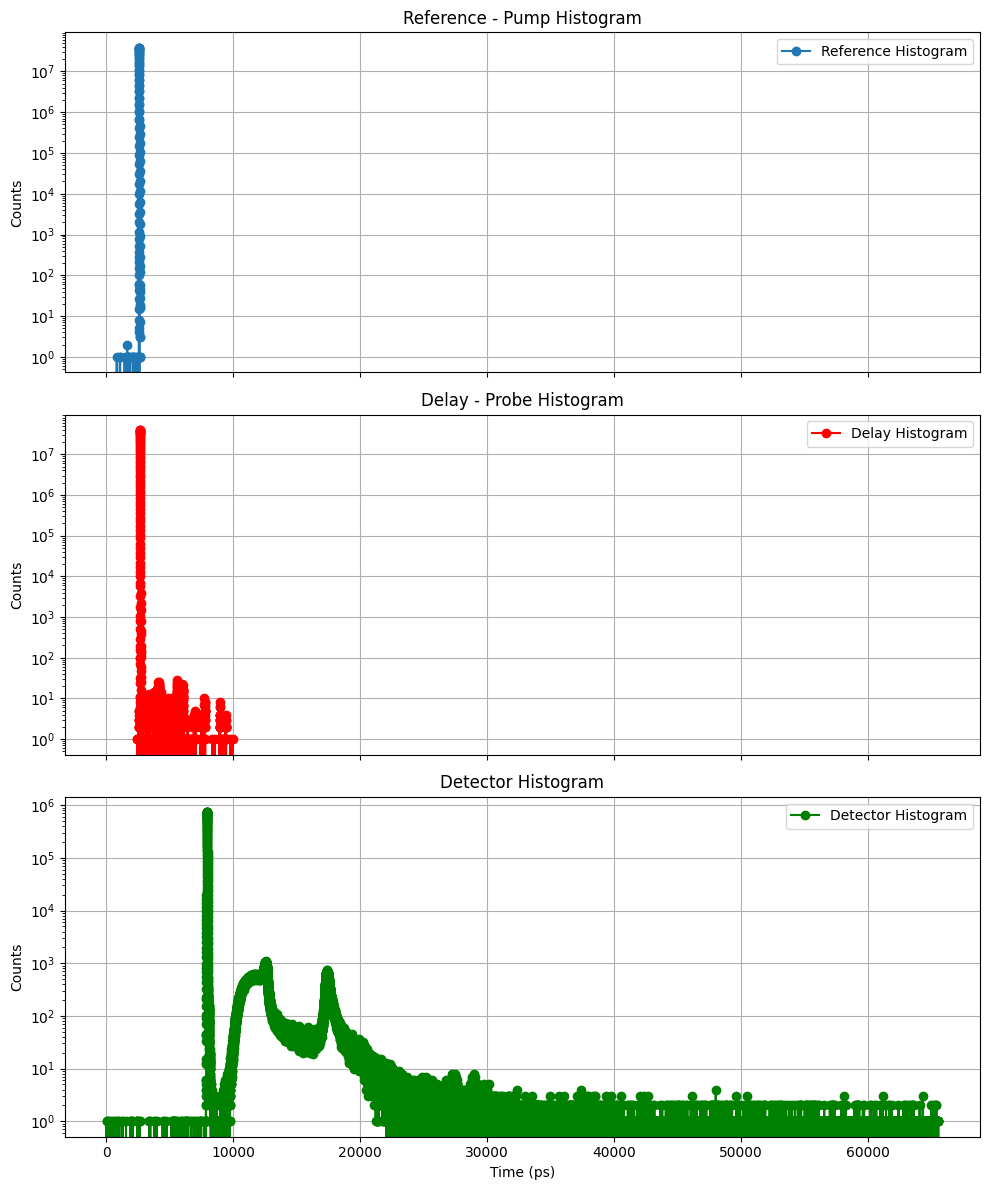

In [311]:
import numpy as np
import matplotlib.pyplot as plt

# Scale time values
time_ps_scaled = time_ps 

# Create figure and axes
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Reference Histogram
axes[0].plot(time_ps_scaled, ref_hist, marker='o', linestyle='-', label="Reference Histogram")
axes[0].set_title("Reference - Pump Histogram")
axes[0].set_ylabel("Counts")
axes[0].legend()
axes[0].set_yscale('log')
axes[0].grid()

# Delay Histogram
axes[1].plot(time_ps_scaled, delay_hist, marker='o', linestyle='-', color='red', label="Delay Histogram")
axes[1].set_title("Delay - Probe Histogram")
axes[1].set_ylabel("Counts")
axes[1].legend()
axes[1].set_yscale('log')
axes[1].grid()

# Detector Histogram
axes[2].plot(time_ps_scaled, detector_hist, marker='o', linestyle='-', color='green', label="Detector Histogram")
axes[2].set_title("Detector Histogram")
axes[2].set_xlabel("Time (ps)")
axes[2].set_ylabel("Counts")
axes[2].set_yscale('log')

axes[2].legend()
axes[2].grid()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [300]:
from scipy.signal import find_peaks

peaks_idx, _ = find_peaks(detector_hist, height=0.001*max(detector_hist), distance=delay_bins/2)
print(peaks_idx)

[ 7717  9729 11027 12350 13289 14315 17321 19153]


In [301]:
pump_counts_M  = detector_hist[peaks_idx[0]]   # since the probe will always be the first gaussian 
probe_counts_H = detector_hist[peaks_idx[1]]   # num of detected counts at the second (probe) peak
t_delay        = max(peaks_idx) - min(peaks_idx)   # time difference between the two peaks in bins

print(f"Pump Pulse Detection Count (M): {pump_counts_M} counts")
print(f"Probe Pulse Detection Count (H): {probe_counts_H} counts")
tot_pulses = sum(detector_hist)
print(f"Total Number of Detected Pulses: {tot_pulses}\n")

pump_m  = pump_counts_M / tot_pulses  
probe_h = probe_counts_H / tot_pulses
availability_s = probe_h/pump_m

print(f"Probability of Detecting Pump Pulse (m): {pump_m:.6f}")
print(f"Probability of Detecting Probe Pulse (h): {probe_h:.6f}")

print(f"\nComputed Availability (S): {availability_s:.6f}")
print(f"Time Delay Between Peaks:  {t_delay} bins\n")

Pump Pulse Detection Count (M): 10539 counts
Probe Pulse Detection Count (H): 9060 counts
Total Number of Detected Pulses: 802299

Probability of Detecting Pump Pulse (m): 0.013136
Probability of Detecting Probe Pulse (h): 0.011293

Computed Availability (S): 0.859664
Time Delay Between Peaks:  11436 bins



[7665 9157]
(array([20.72503869, 40.39720847]), array([316221.5,   1356. ]), array([7655.69232199, 9133.69306931]), array([7676.41736068, 9174.09027778]))


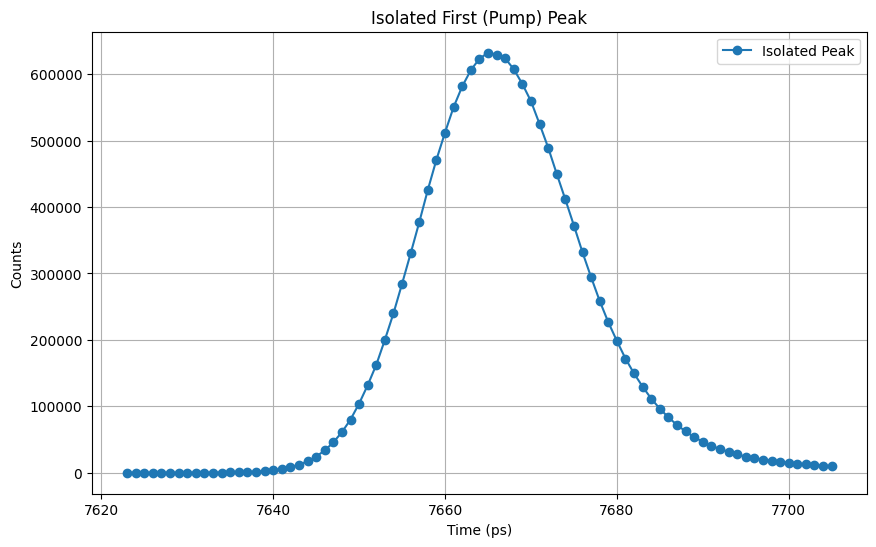

In [192]:
from scipy.signal import peak_widths

# Measure peak width at half maximum
results_half = peak_widths(detector_hist, peaks_idx, rel_height=0.5)
print(peaks_idx)
print(results_half)
# Extract the width of the first peak
peak_width = results_half[0][0]  # Width of first peak

# Define the range for isolation
start_idx = int(peaks_idx[0] - 2* peak_width )
end_idx = int(peaks_idx[0] + 2 * peak_width)
start_idx = max(start_idx, 0)
end_idx = min(end_idx, len(detector_hist) - 1)

plt.figure(figsize=(10, 6))
plt.plot(time_ps[start_idx:end_idx], detector_hist[start_idx:end_idx], label='Isolated Peak', linestyle='-', marker='o')
plt.xlabel("Time (ps)")
plt.ylabel("Counts")
plt.title("Isolated First (Pump) Peak")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# LASER_FREQ = 10 * 1e6 # per second 
# ACQ_TIME = 10 # in seconds
# NUM_LASER_TRIG = LASER_FREQ * ACQ_TIME

detection_prob_per_pulse =  sum(detector_hist[start_idx:end_idx])/sum(ref_hist) 
print(f"Probability of detecting at least one photon per laser pulse: {detection_prob_per_pulse}")

Probability of detecting at least one photon per laser pulse: 3.333286311774429e-08


## Plot availability-delay data

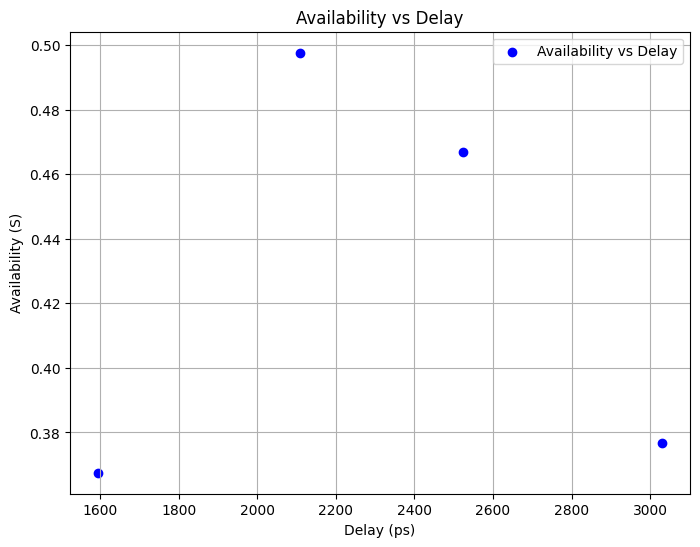

In [307]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
file_path = "analysis/results/availability_delay.txt"
data = pd.read_csv(file_path, sep=" ", skiprows=1, header=None, names=["Availability(S)", "Delay(bins)", "Delay(ps)", " Delay_of_ind(bins)" ])

delay_ps = data["Delay(ps)"]
delay_bins = data["Delay(bins)"]

avail_s  =  data["Availability(S)"]
delay_gauss_bins = data[" Delay_of_ind(bins)"]

plt.figure(figsize=(8, 6))
plt.scatter(delay_ps,avail_s, marker='o', linestyle='-', color='b', label="Availability vs Delay")

plt.xlabel("Delay (ps)")
plt.ylabel("Availability (S)")
plt.title("Availability vs Delay")
plt.legend()
plt.grid()
plt.show()


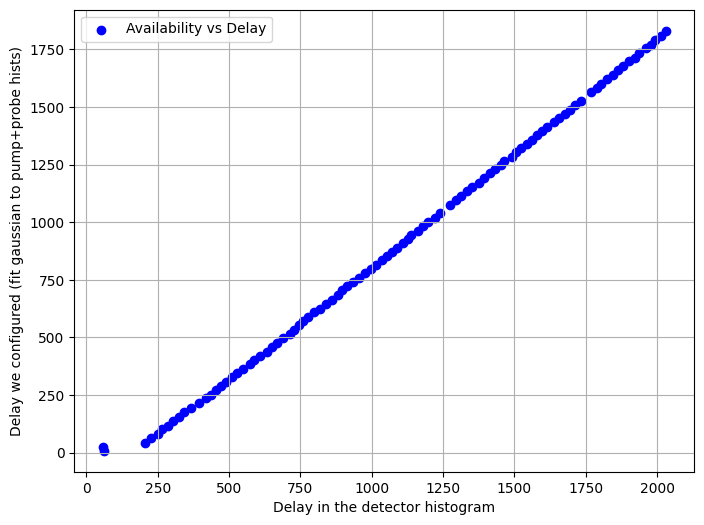

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
file_path = "analysis/results/availability_delay.txt"
data = pd.read_csv(file_path, sep=" ", skiprows=1, header=None, names=["Availability(S)", "Delay(bins)", "Delay(ps)", " Delay_of_ind(bins)" ])

delay_ps = data["Delay(ps)"]
delay_bins = data["Delay(bins)"]
avail_s  =  data["Availability(S)"]
delay_gauss_bins = data[" Delay_of_ind(bins)"]

plt.figure(figsize=(8, 6))
plt.scatter(delay_bins, delay_gauss_bins, marker='o', linestyle='-', color='b', label="Availability vs Delay")

plt.xlabel("Delay in the detector histogram")
plt.ylabel("Delay we configured (fit gaussian to pump+probe hists)")
plt.legend()
plt.grid()
plt.show()

In [214]:
if any(abs(delay_bins - delay_gauss_bins) > 250): 
    print(delay_bins, delay_gauss_bins)

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev

spline_s = splrep(delay_ps, avail_s, k=1)

# Generate fine time points
DT_TDC = 650 #ps
t_fine = np.arange(0, delay_ps.max(), DT_TDC)
y_fine = splev(t_fine, spline_s, ext=1)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(delay_ps, avail_s, color='r', label="Original Data", zorder=2) 
plt.plot(t_fine, y_fine, linestyle='-', color='b', label="Linear Spline Fit", zorder=1)  

plt.xlabel("Delay (ps)")
plt.ylabel("Avaiability")
plt.title("Linear Spline Interpolation")
plt.legend()
plt.grid()
plt.show()


ValueError: Error on input data

## Plot all the results 

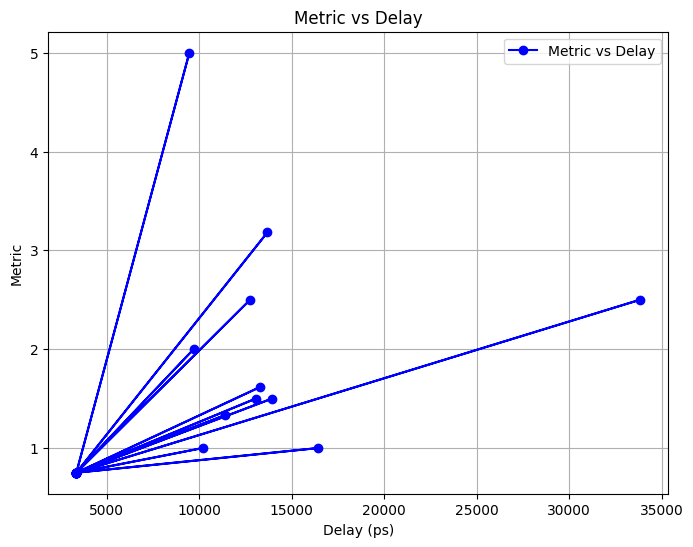

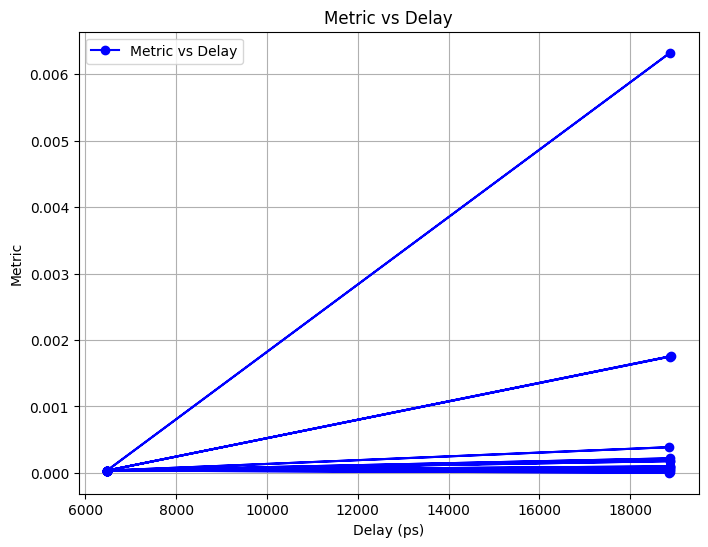

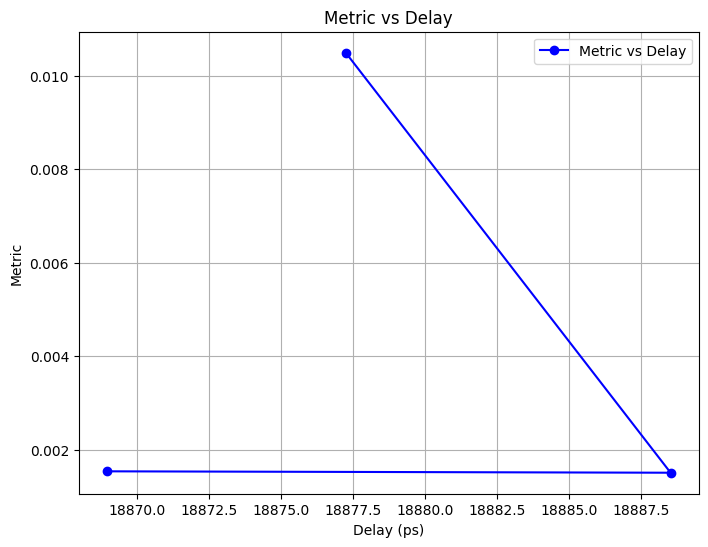

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
# Load the data
files = os.listdir('results/')

for file in files: 
    file_path = "results/" + file
    data = pd.read_csv(file_path, sep=" ", skiprows=1, header=None, names=["Metric", "Delay(bins)", "Delay(ps)"])

    delay_ps = data["Delay(ps)"]
    avail_s  =  data["Metric"]
    plt.figure(figsize=(8, 6))
    plt.plot(data["Delay(ps)"], data["Metric"], marker='o', linestyle='-', color='b', label="Metric vs Delay")

    plt.xlabel("Delay (ps)")
    plt.ylabel("Metric")
    plt.title("Metric vs Delay")
    plt.legend()
    plt.grid()
    plt.show()
